<a href="https://colab.research.google.com/github/StanleyLiangYork/2024_journal_club_Transformer_AI/blob/main/RNN_with_attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook implements a recurrent neurwork network (RNN) with attention mechanism.

The attention mechanism was introduced by Bahdanau et al. (2015), to address the bottleneck problem that arises with the use of a fixed-length encoding vector, where the decoder has limited access to the information provided by the input and becomes a big issue for long and complex sequence. The Bahdanau's  attention mechanism requires to compute the alignment scores, the weights, and the context vector.

The **alignment score** $e_{t,i}$ is compute by the encoded hidden states $h_{i}$ and the previous output $s_{t-1}$ from the decoder to measure how well the elements of the input sequence align with the current output at position $t$ by a function $a( )$:  $e_{t,i} = a(s_{t-1}, h_{i})$. The **weights** $α_{t,i}$ is computed by the alignment score through the softmax function $\alpha_{t,i} = softmax(e_{t,i})$. The **context vector** $c_{t}$ is fed into the decoder at each step from the weighted sum of all $T$ encoder hidden states: $c_{t}\sum_{t=1}^{T}\alpha_{t,i}h_{i}$  

# The general attention mechanism
The general attention mechanism makes use of three main components, namely the queries $Q$, the keys $K$, and the values $V$. Compared to Bahdanau's attention mechanism, the query $Q$ is the previous output $s_{t-1}$ from the decoder, the values $V$ is the encoded inputs $h_{i}$ from the encoder, and the keys $K$ are the same vectors as values $V$。                                                                       

## The Fibonacci sequence
The Fibonacci numbers are a type of sequence where the current number is the sum of the previous two numbers:

0, 1, 1, 2, 3, 5, 8, 13, 21, 34, . . .

It means we can discard all the previous inputs except the last two, then we can correctly get the correct number.

If we make a dataset of the Fibonacci numbers and split them as sequence of 3, the data will look like below:

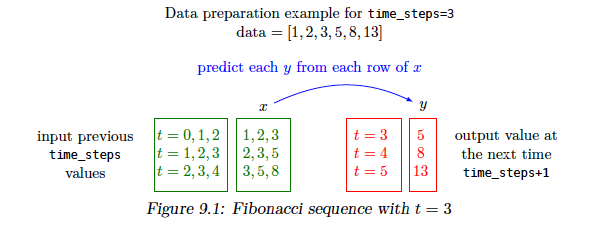

In [1]:
from pandas import read_csv
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense, SimpleRNN
from tensorflow.keras.layers import Layer
from tensorflow.keras.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
import tensorflow.keras.backend as K
import numpy as np

In [2]:
def get_fib_seq(n, scale_data=True):
    # Get the Fibonacci sequence
    # if the scale_data is True, the numbers will be scaled to [0,1]
    seq = np.zeros(n)
    fib_n1 = 0.0
    fib_n = 1.0
    for i in range(n):
            seq[i] = fib_n1 + fib_n
            fib_n1 = fib_n
            fib_n = seq[i]
    scaler = []
    if scale_data:
        scaler = MinMaxScaler(feature_range=(0, 1))
        seq = np.reshape(seq, (n, 1))
        seq = scaler.fit_transform(seq).flatten()
    return seq, scaler

In [3]:
fib_seq, _ = get_fib_seq(10, False)
print(fib_seq)

[ 1.  2.  3.  5.  8. 13. 21. 34. 55. 89.]


In [13]:
def get_fib_XY(total_fib_numbers, time_steps, train_percent, scale_data=True):
    # a function to split the long sequence into fragments as the learning features, and the upcoming number as the label
    dat, scaler = get_fib_seq(total_fib_numbers, scale_data)
    Y_ind = np.arange(time_steps, len(dat), 1)
    Y = dat[Y_ind]
    rows_x = len(Y)
    X = dat[0:rows_x]
    for i in range(time_steps-1):
        temp = dat[i+1:rows_x+i+1]
        X = np.column_stack((X, temp))
    # random permutation with fixed seed
    rand = np.random.RandomState(seed=13)
    idx = rand.permutation(rows_x)
    split = int(train_percent*rows_x)
    train_ind = idx[0:split]
    test_ind = idx[split:]
    trainX = X[train_ind]
    trainY = Y[train_ind]
    testX = X[test_ind]
    testY = Y[test_ind]
    trainX = np.reshape(trainX, (len(trainX), time_steps, 1))
    testX = np.reshape(testX, (len(testX), time_steps, 1))
    return trainX, trainY, testX, testY, scaler

In [14]:
trainX, trainY, testX, testY, scaler = get_fib_XY(12, 3, 0.7, False)
print('trainX = ', trainX)
print('trainY = ', trainY)

trainX =  [[[ 8.]
  [13.]
  [21.]]

 [[ 5.]
  [ 8.]
  [13.]]

 [[ 2.]
  [ 3.]
  [ 5.]]

 [[13.]
  [21.]
  [34.]]

 [[21.]
  [34.]
  [55.]]

 [[34.]
  [55.]
  [89.]]]
trainY =  [ 34.  21.   8.  55.  89. 144.]


## Define a RNN

In [20]:
# Set up parameters
time_steps = 20
hidden_units = 2
epochs = 30

# Create a traditional RNN network
def create_RNN(hidden_units, dense_units, input_shape, activation):
    x = Input(shape=input_shape)
    RNN_layer = SimpleRNN(hidden_units, activation=activation[0])(x)
    outputs = Dense(dense_units, activation=activation[1])(RNN_layer)
    model = Model(x,outputs)
    model.compile(loss='mse', optimizer='adam')
    return model

In [21]:
model_RNN = create_RNN(hidden_units=hidden_units, dense_units=1,
                       input_shape=(time_steps,1), activation=['tanh', 'tanh'])

model_RNN.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 20, 1)]           0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 2)                 8         
                                                                 
 dense_1 (Dense)             (None, 1)                 3         
                                                                 
Total params: 11 (44.00 Byte)
Trainable params: 11 (44.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [17]:
# Generate the dataset - 1200 points, break into fragments of 20, use 70% for training
trainX, trainY, testX, testY, scaler  = get_fib_XY(1200, time_steps, 0.7)

model_RNN.fit(trainX, trainY, epochs=epochs, batch_size=1, verbose=2)

# Evalute model
train_mse = model_RNN.evaluate(trainX, trainY)
test_mse = model_RNN.evaluate(testX, testY)

# Print error
print("Train set MSE = ", train_mse)
print("Test set MSE = ", test_mse)

Epoch 1/30
826/826 - 4s - loss: 0.0033 - 4s/epoch - 5ms/step
Epoch 2/30
826/826 - 3s - loss: 0.0033 - 3s/epoch - 3ms/step
Epoch 3/30
826/826 - 2s - loss: 0.0031 - 2s/epoch - 3ms/step
Epoch 4/30
826/826 - 2s - loss: 0.0030 - 2s/epoch - 3ms/step
Epoch 5/30
826/826 - 2s - loss: 0.0029 - 2s/epoch - 3ms/step
Epoch 6/30
826/826 - 2s - loss: 0.0028 - 2s/epoch - 3ms/step
Epoch 7/30
826/826 - 3s - loss: 0.0026 - 3s/epoch - 4ms/step
Epoch 8/30
826/826 - 2s - loss: 0.0025 - 2s/epoch - 3ms/step
Epoch 9/30
826/826 - 2s - loss: 0.0024 - 2s/epoch - 3ms/step
Epoch 10/30
826/826 - 2s - loss: 0.0024 - 2s/epoch - 3ms/step
Epoch 11/30
826/826 - 2s - loss: 0.0023 - 2s/epoch - 2ms/step
Epoch 12/30
826/826 - 2s - loss: 0.0022 - 2s/epoch - 3ms/step
Epoch 13/30
826/826 - 3s - loss: 0.0021 - 3s/epoch - 4ms/step
Epoch 14/30
826/826 - 2s - loss: 0.0021 - 2s/epoch - 3ms/step
Epoch 15/30
826/826 - 3s - loss: 0.0020 - 3s/epoch - 3ms/step
Epoch 16/30
826/826 - 3s - loss: 0.0020 - 3s/epoch - 3ms/step
Epoch 17/30
826/8

# RNN with attention

In [18]:
# define a custom attention class

class attention(Layer):
    def __init__(self,**kwargs):
        super().__init__(**kwargs)

    def build(self,input_shape):
       # set a weight matrix for the attention score
        self.W=self.add_weight(name='attention_weight', shape=(input_shape[-1],1),
                               initializer='random_normal', trainable=True)
        # set a bias vector for the attention score
        self.b=self.add_weight(name='attention_bias', shape=(input_shape[1],1),
                               initializer='zeros', trainable=True)
        super().build(input_shape)

    def call(self,x):
        # Alignment scores. Pass them through tanh function
        e = K.tanh(K.dot(x,self.W)+self.b)
        # Remove dimension of size 1
        e = K.squeeze(e, axis=-1)
        # Compute the weights
        alpha = K.softmax(e)
        # Reshape to tensorFlow format
        alpha = K.expand_dims(alpha, axis=-1)
        # Compute the context vector
        # in general attention mechanism, query and value are the same vector
        context = x * alpha
        context = K.sum(context, axis=1)
        return context

# An RNN with the general attention layer

In [19]:
def create_RNN_with_attention(hidden_units, dense_units, input_shape, activation):
    x = Input(shape=input_shape)
    RNN_layer = SimpleRNN(hidden_units, return_sequences=True, activation=activation)(x)
    attention_layer = attention()(RNN_layer)
    outputs = Dense(dense_units, trainable=True, activation=activation)(attention_layer)
    model = Model(x,outputs)
    model.compile(loss='mse', optimizer='adam')
    return model

In [22]:
model_attention = create_RNN_with_attention(hidden_units=hidden_units, dense_units=1,
                                            input_shape=(time_steps,1), activation='tanh')

model_attention.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 20, 1)]           0         
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 20, 2)             8         
                                                                 
 attention (attention)       (None, 2)                 22        
                                                                 
 dense_2 (Dense)             (None, 1)                 3         
                                                                 
Total params: 33 (132.00 Byte)
Trainable params: 33 (132.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [23]:
model_attention.fit(trainX, trainY, epochs=epochs, batch_size=1, verbose=2)

Epoch 1/30
826/826 - 5s - loss: 0.0015 - 5s/epoch - 6ms/step
Epoch 2/30
826/826 - 2s - loss: 0.0015 - 2s/epoch - 3ms/step
Epoch 3/30
826/826 - 2s - loss: 0.0014 - 2s/epoch - 3ms/step
Epoch 4/30
826/826 - 3s - loss: 0.0014 - 3s/epoch - 3ms/step
Epoch 5/30
826/826 - 3s - loss: 0.0014 - 3s/epoch - 3ms/step
Epoch 6/30
826/826 - 4s - loss: 0.0013 - 4s/epoch - 4ms/step
Epoch 7/30
826/826 - 2s - loss: 0.0013 - 2s/epoch - 3ms/step
Epoch 8/30
826/826 - 2s - loss: 0.0013 - 2s/epoch - 3ms/step
Epoch 9/30
826/826 - 2s - loss: 0.0012 - 2s/epoch - 3ms/step
Epoch 10/30
826/826 - 3s - loss: 0.0012 - 3s/epoch - 4ms/step
Epoch 11/30
826/826 - 5s - loss: 0.0011 - 5s/epoch - 6ms/step
Epoch 12/30
826/826 - 2s - loss: 0.0011 - 2s/epoch - 3ms/step
Epoch 13/30
826/826 - 2s - loss: 0.0010 - 2s/epoch - 3ms/step
Epoch 14/30
826/826 - 2s - loss: 9.5179e-04 - 2s/epoch - 3ms/step
Epoch 15/30
826/826 - 2s - loss: 8.7772e-04 - 2s/epoch - 3ms/step
Epoch 16/30
826/826 - 3s - loss: 7.9808e-04 - 3s/epoch - 4ms/step
Epoch

In [24]:
# Evalute model
train_mse_attn = model_attention.evaluate(trainX, trainY)
test_mse_attn = model_attention.evaluate(testX, testY)

12/12 [==============================] - 0s 3ms/step - loss: 9.7301e-06


In [25]:
# Print error
print("Train set MSE with attention = ", train_mse_attn)
print("Test set MSE with attention = ", test_mse_attn)

Train set MSE with attention =  0.00010691628267522901
Test set MSE with attention =  9.7301408459316e-06


From the above example, we can see the RNN with attention gets much better prediction results compared to the RNN without the attention mechanism.